<a href="https://colab.research.google.com/github/pawan-cpu/Learn-Python-with-Pawan-Kumar/blob/main/L19Jan_2022_01_18_pawan_lesson56.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lesson 56: Multicollinearity


|Particulars|Description|
|-|-|
|**Topics Covered**|Estimating Betas|
||Multicollinearity|
|||
|**Lesson Description**|A student learns to estimate betas using matrix operations and remove multicollinearity from a multiple linear regression model.|
|||
|**Lesson Duration**|50 minutes|
|||
|**Learning Outcomes**|Estimate betas using matrix operations.|
||Remove multicollinearity from a multiple linear regression model|




---

### Teacher-Student Tasks

In this class, you will learn how to estimate the values of betas using matrix operations and the concept of multicollinearity.

Let's quickly run the codes covered in the previous classes and begin this session from **Task 1: Estimating Betas Through Matrix Operations** section.

---

In [ ]:
# Run the code cell.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Loading the dataset.
csv_file = 'https://student-datasets-bucket.s3.ap-south-1.amazonaws.com/whitehat-ds-datasets/air-quality/AirQualityUCI.csv'
df = pd.read_csv(csv_file, sep=';')

# Dropping the 'Unnamed: 15' & 'Unnamed: 16' columns.
df = df.drop(columns=['Unnamed: 15', 'Unnamed: 16'], axis=1) 

# Dropping the null values.
df = df.dropna()

# Creating a Pandas series containing 'datetime' objects.
dt_series = pd.Series(data = [item.split("/")[2] + "-" + item.split("/")[1] + "-" + item.split("/")[0] for item in df['Date']], index=df.index) + ' ' + pd.Series(data=[str(item).replace(".", ":") for item in df['Time']], index=df.index)
dt_series = pd.to_datetime(dt_series)

# Remove the Date & Time columns from the DataFrame and insert the 'dt_series' in it.
df = df.drop(columns=['Date', 'Time'], axis=1)
df.insert(loc=0, column='DateTime', value=dt_series)

# Get the Pandas series containing the year values as integers.
year_series = dt_series.dt.year

# Get the Pandas series containing the month values as integers.
month_series = dt_series.dt.month

# Get the Pandas series containing the day values as integers.
day_series = dt_series.dt.day

# Get the Pandas series containing the days of a week, i.e., Monday, Tuesday, Wednesday etc.
day_name_series = dt_series.dt.day_name()

# Add the 'Year', 'Month', 'Day' and 'Day Name' columns to the DataFrame.
df['Year'] = year_series
df['Month'] = month_series
df['Day'] = day_series
df['Day Name'] = day_name_series

# Sort the DataFrame by the 'DateTime' values in the ascending order. Also, display the first 10 rows of the DataFrame.
df = df.sort_values(by='DateTime')

# Create a function to replace the commas with periods in a Pandas series.
def comma_to_period(series):
    new_series = pd.Series(data=[float(str(item).replace(',', '.')) for item in series], index=df.index)
    return new_series

# Apply the 'comma_to_period()' function on the ''CO(GT)', 'C6H6(GT)', 'T', 'RH' and 'AH' columns.
cols_to_correct = ['CO(GT)', 'C6H6(GT)', 'T', 'RH', 'AH'] # Create a list of column names.
for col in cols_to_correct: # Iterate through each column
    df[col] = comma_to_period(df[col]) # Replace the original column with the new series.

# Remove all the columns from the 'df' DataFrame containing more than 10% garbage value.
df = df.drop(columns=['NMHC(GT)', 'CO(GT)', 'NOx(GT)', 'NO2(GT)'], axis=1)

# Create a new DataFrame containing records for the years 2004 and 2005.
aq_2004_df = df[df['Year'] == 2004]
aq_2005_df = df[df['Year'] == 2005]

# Replace the -200 value with the median values for each column having indices between 1 and -4 (excluding -4) for the 2004 year DataFrame.
for col in aq_2004_df.columns[1:-4]:
  median = aq_2004_df.loc[aq_2004_df[col] != -200, col].median()
  aq_2004_df[col] = aq_2004_df[col].replace(to_replace=-200, value=median)

# Repeat the same exercise for the 2005 year DataFrame.
for col in aq_2005_df.columns[1:-4]:
  median = aq_2005_df.loc[aq_2005_df[col] != -200, col].median()
  aq_2005_df[col] = aq_2005_df[col].replace(to_replace=-200, value=median)

# Group the DataFrames about the 'Month' column.
group_2004_month = aq_2004_df.groupby(by='Month')
group_2005_month = aq_2005_df.groupby(by='Month')

# Concatenate the two DataFrames for 2004 and 2005 to obtain one DataFrame.
df = pd.concat([aq_2004_df, aq_2005_df])

# Information of the DataFrame.
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9357 entries, 0 to 9356
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   DateTime       9357 non-null   datetime64[ns]
 1   PT08.S1(CO)    9357 non-null   float64       
 2   C6H6(GT)       9357 non-null   float64       
 3   PT08.S2(NMHC)  9357 non-null   float64       
 4   PT08.S3(NOx)   9357 non-null   float64       
 5   PT08.S4(NO2)   9357 non-null   float64       
 6   PT08.S5(O3)    9357 non-null   float64       
 7   T              9357 non-null   float64       
 8   RH             9357 non-null   float64       
 9   AH             9357 non-null   float64       
 10  Year           9357 non-null   int64         
 11  Month          9357 non-null   int64         
 12  Day            9357 non-null   int64         
 13  Day Name       9357 non-null   object        
dtypes: datetime64[ns](1), float64(9), int64(3), object(1)
memory usage: 1.1+

The description for all the columns containing data for air pollutants, temperature, relative humidity and absolute humidity is provided below.


|Columns|Description|
|-|-|
|PT08.S1(CO)|PT08.S1 (tin oxide) hourly averaged sensor response (nominally $\text{CO}$ targeted)|
|C6H6(GT)|True hourly averaged Benzene concentration in $\frac{\mu g}{m^3}$|
|PT08.S2(NMHC)|PT08.S2 (titania) hourly averaged sensor response (nominally $\text{NMHC}$ targeted)|
|PT08.S3(NOx)|PT08.S3 (tungsten oxide) hourly averaged sensor response (nominally $\text{NO}_x$ targeted)|
|PT08.S4(NO2)|PT08.S4 (tungsten oxide) hourly averaged sensor response (nominally $\text{NO}_2$ targeted)|
|PT08.S5(O3) |PT08.S5 (indium oxide) hourly averaged sensor response (nominally $\text{O}_3$ targeted)|
|T|Temperature in Â°C|
|RH|Relative Humidity (%)|
|AH|AH Absolute Humidity|

---

#### Multiple Linear Regression Model Using `sklearn` Module


In [ ]:
# Build a linear regression model using the sklearn module by including all the features listed above.
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

features = list(df.columns.values[1:-1])
features.remove('RH')

X = df[features]
y = df['RH']

# Splitting the DataFrame into the train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42) # Test set will have 33% of the values.

y_train_reshaped = y_train.values.reshape(-1, 1)
y_test_reshaped = y_test.values.reshape(-1, 1)

# Build a linear regression model using the 'sklearn.linear_model' module.
sklearn_lin_reg = LinearRegression()
sklearn_lin_reg.fit(X_train, y_train_reshaped)

# Print the value of the intercept i.e. beta-sub-0.
print("\nConstant".ljust(15, " "), f"{sklearn_lin_reg.intercept_[0]:.6f}") # Soon you will get to know why rounding-off to 6 decimal places.

# Print the names of the features along with the values of their corresponding coefficients.
for item in list(zip(X.columns.values, sklearn_lin_reg.coef_[0])):
  print(f"{item[0]}".ljust(15, " "), f"{item[1]:.6f}") # Soon you will get to know why rounding-off to 6 decimal places.


Constant       -15028.451823
PT08.S1(CO)     0.014833
C6H6(GT)        -0.903464
PT08.S2(NMHC)   -0.005881
PT08.S3(NOx)    0.001503
PT08.S4(NO2)    0.026497
PT08.S5(O3)     -0.001066
T               -2.354919
AH              29.551742
Year            7.505153
Month           1.167861
Day             0.035232


In [ ]:
# Evaluate the linear regression model using the 'r2_score', 'mean_squared_error' & 'mean_absolute_error' functions of the 'sklearn' module.
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

y_train_pred = sklearn_lin_reg.predict(X_train)
y_test_pred = sklearn_lin_reg.predict(X_test)

print(f"Train Set\n{'-' * 50}")
print(f"R-squared: {r2_score(y_train_reshaped, y_train_pred):.3f}")
print(f"Mean Squared Error: {mean_squared_error(y_train_reshaped, y_train_pred):.3f}")
print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_train_reshaped, y_train_pred)):.3f}")
print(f"Mean Absolute Error: {mean_absolute_error(y_train_reshaped, y_train_pred):.3f}")
      
print(f"\n\nTest Set\n{'-' * 50}")
print(f"R-squared: {r2_score(y_test_reshaped, y_test_pred):.3f}")
print(f"Mean Squared Error: {mean_squared_error(y_test_reshaped, y_test_pred):.3f}")
print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_test_reshaped, y_test_pred)):.3f}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test_reshaped, y_test_pred):.3f}")

Train Set
--------------------------------------------------
R-squared: 0.879
Mean Squared Error: 35.116
Root Mean Squared Error: 5.926
Mean Absolute Error: 4.572


Test Set
--------------------------------------------------
R-squared: 0.879
Mean Squared Error: 34.702
Root Mean Squared Error: 5.891
Mean Absolute Error: 4.564


---

#### The `statsmodels.api` Module

In [ ]:
# Build a linear regression model using the 'statsmodels.api' module.
import statsmodels.api as sm

# Create data frames for the features and target again and also split them into the train and test sets.
X = df[features]
y = df['RH']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42) # Test set will have 33% of the values.

# Add a constant to get an intercept
X_train_sm = sm.add_constant(X_train)

# Fit the regression line using 'OLS'
lr = sm.OLS(y_train, X_train_sm).fit()

# Print the parameters, i.e. the intercept and the slope of the regression line fitted
lr.params

const           -15028.451823
PT08.S1(CO)          0.014833
C6H6(GT)            -0.903464
PT08.S2(NMHC)       -0.005881
PT08.S3(NOx)         0.001503
PT08.S4(NO2)         0.026497
PT08.S5(O3)         -0.001066
T                   -2.354919
AH                  29.551742
Year                 7.505153
Month                1.167861
Day                  0.035232
dtype: float64

The above values for the constant and the coefficients of all the features are almost the same as the ones obtained through the `sklearn` linear regression model.

In [ ]:
# Performing a summary operation lists out all the different parameters of the regression line fitted
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:                     RH   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.878
Method:                 Least Squares   F-statistic:                     4115.
Date:                Tue, 18 Jan 2022   Prob (F-statistic):               0.00
Time:                        04:34:31   Log-Likelihood:                -20050.
No. Observations:                6269   AIC:                         4.012e+04
Df Residuals:                    6257   BIC:                         4.020e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -1.503e+04   1240.167    -12.118

---

#### Ordinary Least Squares (OLS)

Consider the regression equation

$$Y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_3 + \dots + \beta_k x_k + \epsilon$$

where 

- $x_1, x_2, x_3, \dots , x_k$ are independent variables or features

- $Y$ is the response to the independent variable (or predicted value or dependent variable)

- $\beta_0, \beta_1, \beta_2, \dots, \beta_k$ are the corresponding regression coefficients of the independent variables

- **$\epsilon$** is the random error obtained along with the predicted value which follows a normal distribution with mean $0$ and some standard deviation of $\sigma$


The parameters $\beta_0, \beta_1, \beta_2, \dots, \beta_n$ and $\sigma$ are assumed to be unknown and must be estimated from the data, which we shall suppose consist of the values of $Y_1, Y_2, Y_3, \dots , Y_n$ where $Y_i$ is the response level corresponding to the $k$ features $x_{i1}, \dots , x_{i2}, \dots , x_{ik}$ . That is, the $Y_i$ are related to these features through

$$E[Y_i] = \beta_0 + \beta_1 x_{i1} + \beta_2 x_{i2} + \beta_3 x_{i3} + \dots + \beta_k x_{ik}$$

where 

- $E[Y_i]$ means **expected value** for an instance $i$. In simple terms, instance or $i$ denotes a row in a data frame

- $x_{i1}$ denotes item at the $i^{\text{th}}$ row in the $1^{\text{st}}$ column in a data frame having only features

- $x_{i2}$ denotes item at the $i^{\text{th}}$ row in the $2^{\text{nd}}$ column in a data frame having only features

- $x_{i3}$ denotes item at the $i^{\text{th}}$ row in the $3^{\text{rd}}$ column in a data frame having only features

  $\dots$

- $x_{ik}$ denotes item at the $i^{\text{th}}$ row in the $k^{\text{th}}$ column in a data frame having only features

For e.g., in the `X` DataFrame there are $9357$ rows. So let $x_1, x_2, x_3, \dots , x_{11}$ denote $\text{CO}, \text{C}_6 \text{H}_6, \text{NMHC}, \dots, \text{day}$ respectively.


As we said earlier, the difference between the actual and the predicted values should be 0 or close to 0 for an accurate prediction model i.e.

$$Y_1 - E[Y_1] \approx 0$$

$$Y_2 - E[Y_2] \approx 0$$

$$Y_3 - E[Y_3] \approx 0$$

$$\vdots$$

$$Y_N - E[Y_N] \approx 0$$

where $N$ is the total number of instances (or rows in a data frame).

**The OLS says that the sum of squares of all these errors i.e.**

$$J = (Y_1 - E[Y_1])^2 + (Y_2 - E[Y_2])^2 + (Y_3 - E[Y_3])^2 + \dots + (Y_N - E[Y_N])^2$$

**should be the least or minimum.** 

The above expression can be compressed as
$$J = \sum_{i = 1}^{N}(Y_i - E[Y_i])^2$$

So in general, it can be written as

$$J(\beta, x) = \sum_{i = 1}^{N}(Y_i - \beta_0 - \beta_1 x_{i1} - \beta_2 x_{i2} - \beta_3 x_{i3} - \dots - \beta_k x_{ik})^2 $$

where $J(\beta, x)$ denotes the sum of the squared errors is dependent on the coefficients ($\beta_0, \beta_1, \beta_2, \dots, \beta_k$) and features ($x_1, x_2, x_3, \dots , x_k$)


Partially differentiating $J(\beta, x)$ w.r.t. $\beta_0$. So every other term apart from $\beta_0$ will be treated as a constant. And the differentiation (or derivative) of a constant is 0.

$$\frac{\partial J}{\partial \beta_0} = 2 \sum_{i = 1}^{N}(Y_i - \beta_0 - \beta_1 x_{i1} - \beta_2 x_{i2} - \beta_3 x_{i3} - \dots - \beta_k x_{ik})(-1) = 0$$

$$\Rightarrow \sum_{i = 1}^{N}(Y_i - \beta_0 - \beta_1 x_{i1} - \beta_2 x_{i2} - \beta_3 x_{i3} - \dots - \beta_k x_{ik}) = 0$$

Similarly, 

$$\sum_{i = 1}^{N}(Y_i - \beta_0 - \beta_1 x_{i1} - \beta_2 x_{i2} - \beta_3 x_{i3} - \dots - \beta_k x_{ik})x_{i1} = 0$$

$$\sum_{i = 1}^{N}(Y_i - \beta_0 - \beta_1 x_{i1} - \beta_2 x_{i2} - \beta_3 x_{i3} - \dots - \beta_k x_{ik})x_{i2} = 0$$

$$\vdots$$

$$\sum_{i = 1}^{N}(Y_i - \beta_0 - \beta_1 x_{i1} - \beta_2 x_{i2} - \beta_3 x_{i3} - \dots - \beta_k x_{ik})x_{ik} = 0$$


On further reducing the above $k + 1$ equations, we get

$$\sum_{i = 1}^{N}Y_i = N \beta_0 + \beta_1 \sum_{i = 1}^{N}x_{i1} + \beta_2 \sum_{i = 1}^{N}x_{i2} + \beta_3 \sum_{i = 1}^{N} x_{i3} + \dots + \beta_k \sum_{i = 1}^{N} x_{ik}$$

$$\sum_{i = 1}^{N}Y_i x_{i1} = \beta_0 \sum_{i = 1}^{N}x_{i1} + \beta_1 \sum_{i = 1}^{N}x_{i1}^2 + \beta_2 \sum_{i = 1}^{N} x_{i1} x_{i2} + \dots + \beta_k \sum_{i = 1}^{N} x_{i1} x_{ik}$$

$$\vdots$$

$$\sum_{i = 1}^{N}Y_i x_{ik} = \beta_0 \sum_{i = 1}^{N}x_{ik} + \beta_1 \sum_{i = 1}^{N} x_{ik} x_{i1} + \beta_2 \sum_{i = 1}^{N} x_{ik} x_{i2} + \dots + \beta_k \sum_{i = 1}^{N} x_{ik}^2$$


Now we have $k + 1$ linear equations having $k + 1$ unknowns i.e. $\beta_0, \beta_1, \beta_2, \dots, \beta_k$ . By solving these $k + 1$ equations, we can get the beta values. 

---

#### Multiplicative Inverse of a Matrix

To convert a square matrix into an identity matrix, you have to multiply the matrix with its multiplicative inverse (or inverse). 

Let $A$ be a square matrix of the dimension $n \times n$ or $n$. Then its inverse matrix (if it exists) is denoted by $A^{-1}$. Hence

$$A^{-1}_n A_n = I_n$$

where $I_n$ is an identity matrix of the dimension $n$.

Here, $A^{-1}$ is the inverse matrix of $A$. Conversely, $A$ is also an inverse of the matrix $A^{-1}$.

Eg. let $A$ be a matrix of dimension $3$

$$A = \begin{bmatrix} 1 & 3 & 3 \\ 1 & 4 & 3 \\ 1 & 3 & 4 \\\end{bmatrix}$$

Then its inverse is

$$A^{-1} = \begin{bmatrix} 7 & - 3 & -3 \\ -1 & 1 & 0 \\ -1 & 0 & 1 \\\end{bmatrix}$$

Both $A$ and $A^{-1}$ have the same dimension.

If you multiply the matrix $A$ with its inverse, you should get the identity matrix of dimension $3$.

$$A^{-1} A = \begin{bmatrix} 7 & - 3 & -3 \\ -1 & 1 & 0 \\ -1 & 0 & 1 \\\end{bmatrix} \begin{bmatrix} 1 & 3 & 3 \\ 1 & 4 & 3 \\ 1 & 3 & 4 \\\end{bmatrix}$$

$$\Rightarrow A^{-1}A = \begin{bmatrix} 7 \times 1 - 3 \times 1 -3 \times 1 &7 \times 3 - 3 \times 4 -3 \times 3 & 7 \times 3 - 3 \times 3 - 3 \times 4 \\ -1 \times 1 + 1 \times 1 + 0 \times 1 & -1 \times 3 + 1 \times 4 + 0 \times 3 & -1 \times 3 + 1 \times 3 + 0 \times 4 \\ -1 \times 1 + 0 \times 1 + 1 \times 1 & -1 \times 3 + 0 \times 4 + 1 \times 3 & -1 \times 3 + 0 \times 3 + 1 \times 4 \\\end{bmatrix}$$

$$\Rightarrow A^{-1}A = \begin{bmatrix} 1 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & 0 & 1 \\\end{bmatrix}$$

**Note:** 

1. Unlike some number, say $10^{-1} = \frac{1}{10}$, in the case of a matrix, $A^{-1} \neq \frac{1}{A}$ because a matrix is not a numeric quantity. Rather it is a collection or a two-dimensional array of numeric quantities. Hence, it cannot be treated like a number.

2. The multiplication of a square matrix with its inverse is commutative i.e. 
$$A^{-1}_n A_n = A_n A^{-1}_n = I_n$$

3. The inverse of inverse matrix results in the original matrix
i.e.
$$(A^{-1}_n)^{-1} = A_n$$

To calculate the inverse of a square matrix, you need to follow the steps described below:

1. Create a square matrix containing the cofactors of each element in the original square matrix

2. Take the transpose of the matrix obtained in the first step. The new matrix that is obtained is called the **adjoint** of a matrix.

3. Divide the matrix obtained in the previous step with the determinant value of the original matrix.

Mathematically, the inverse of a square matrix of the dimension $n$ is given by

$$A^{-1}_n = \frac{\text{adj}(A_n)}{\text{det}(A_n)}$$

where

- $\text{adj}(A_n)$ denotes the adjoint of the matrix $A_n$ and

- $\text{det}(A_n)$ denotes the determinant value of the matrix $A_n$

We will now learn how to find the inverse of a matrix. But before that let's learn how to calculate the determinant of a matrix.

---

#### Determinant of a Matrix

A determinant is a numeric value associated with a square matrix. Let's understand this concept with the help of an example. Consider the square matrix of dimension $2$ given below.

$$X = \begin{bmatrix} 8 & 7 \\ 3	& -5 \\\end{bmatrix}$$

Its determinant value i.e. $\text{det}(X)$ is given as

$$\text{det}(X)= \begin{vmatrix} 8 & 7 \\ 3	& -5 \\\end{vmatrix}$$

Simply replace the square brackets with the two vertical bars.

To calculate the determinant of a two-dimensional matrix, multiply the elements of the diagonals and then subtract them

$$\text{det}(X) = 8 \times (-5) - 7 \times 3$$

$$\Rightarrow \text{det}(X) = -40 - 21 = -61$$

$$\Rightarrow \text{det}(X) = -61$$

In general, for a two-dimensional matrix 

$$A_2 = \begin{bmatrix} a_{11} & a_{12} \\ a_{21} & a_{22} \\\end{bmatrix}$$

its determinant value is given as

$$\text{det}(A) = a_{11} \times a_{22} - a_{12} \times a_{21}$$

The above determinant calculation process is shown in the image below

<center><img src = "https://student-datasets-bucket.s3.ap-south-1.amazonaws.com/images/2-dim-mat-mul.png" width = 150></center>

i.e. 

1. Multiply $a_{11}$ with $a_{22}$

2. Multiply $a_{12}$ with $a_{21}$

3. Subtract the product obtained in $(2)$ with the product obtained in $(1)$

Similarly, you can also calculate the determinant of a three-dimensional matrix. Consider the square matrix of dimension $3$ given below.

$$A = \begin{bmatrix} 1 & 3 & 3 \\ 1 & 4 & 3 \\ 1 & 3 & 4 \\\end{bmatrix}$$

Its determinant value i.e. $\text{det}(A)$ is given as

$$\text{det}(A) = \begin{vmatrix} 1 & 3 & 3 \\ 1 & 4 & 3 \\ 1 & 3 & 4 \\\end{vmatrix}$$

Now to calculate the determinant value of a matrix, you need to expand it either along a row or a column. Hence, there are **six** ways to calculate the determinant of a three-dimensional as there are 3 rows and 3 columns.

Let's expand the above determinant about the **first row**.

$$\text{det}(A) = 1 \times \begin{vmatrix} 4 & 3 \\ 3 & 4 \\\end{vmatrix} - 3 \times \begin{vmatrix} 1 & 3 \\ 1 & 4 \\\end{vmatrix} + 3 \times \begin{vmatrix} 1 & 4 \\ 1 & 3 \\\end{vmatrix}$$

On further solving, we get


$$\Rightarrow \text{det}(A) = 1$$

The term

- $\begin{vmatrix} 4 & 3 \\ 3 & 4 \\\end{vmatrix}$ is the cofactor of 1

- $(-1) \times \begin{vmatrix} 1 & 3 \\ 1 & 4 \\\end{vmatrix}$ is the cofactor of 3

- $\begin{vmatrix} 1 & 4 \\ 1 & 3 \\\end{vmatrix}$ is the cofactor of 3

To generalise the process of calculation of the determinant of a square matrix, consider a general square matrix, say $A$, of dimension 3

$$A_3 = \begin{bmatrix}a_{11} & a_{12} & a_{13} \\ a_{21} & a_{22} & a_{23} \\ a_{31} & a_{32} & a_{33}  \\\end{bmatrix}$$

So, in general, the determinant of a square matrix $A_3$ is given by 

$$\text{det}(A_3) = a_{11} C_{11} + a_{12} C_{12} + a_{13} C_{13}$$

where

- $C_{11}$ is the cofactor of $a_{11}$ and 
  $$C_{11} = (-1)^{1 + 1} \begin{vmatrix} a_{22} & a_{23} \\ a_{32} & a_{33} \\\end{vmatrix}$$

- $C_{12}$ is the cofactor of $a_{12}$ and 
  $$C_{12} = (-1)^{1 + 2} \begin{vmatrix} a_{21} & a_{23} \\ a_{31} & a_{33} \\\end{vmatrix}$$

- $C_{13}$ is the cofactor of $a_{13}$ and 
  $$C_{13} = (-1)^{1 + 3} \begin{vmatrix} a_{21} & a_{22} \\ a_{31} & a_{32} \\\end{vmatrix}$$

In general, the cofactor of an element $a_{ij}$ where $i$ is the row number and $j$ is the column number, given by

$$C_{ij} = (-1)^{i + j} \times M_{ij}$$

where $M_{ij}$ is the **determinant of a matrix obtained by removing all the items from the $i^{\text{th}}$ row and the $j^{\text{th}}$ column of the original matrix.**

Similarly, the determinant of a square matrix $A$ can be given by either of the following:

- $\text{det}(A_3) = a_{21} C_{21} + a_{22} C_{22} + a_{23} C_{23}$

- $\text{det}(A_3) = a_{31} C_{31} + a_{32} C_{32} + a_{33} C_{33}$

- $\text{det}(A_3) = a_{11} C_{11} + a_{21} C_{21} + a_{31} C_{31}$

- $\text{det}(A_3) = a_{12} C_{12} + a_{22} C_{22} + a_{32} C_{32}$

- $\text{det}(A_3) = a_{13} C_{13} + a_{23} C_{23} + a_{33} C_{33}$


---

#### Adjoint Matrix

Consider a square matrix $A$ of dimension $3$ i.e.

$$A_3 = \begin{bmatrix}a_{11} & a_{12} & a_{13} \\ a_{21} & a_{22} & a_{23} \\ a_{31} & a_{32} & a_{33}  \\\end{bmatrix}$$

The adjoint of matrix $A$ is given be

$$\text{adj}(A) = \begin{bmatrix}C_{11} & C_{12} & C_{13} \\ C_{21} & C_{22} & C_{23} \\ C_{31} & C_{32} & C_{33} \\\end{bmatrix}^T$$

where 

- $C_{ij}$ is the cofactor of the element $a_{ij}$

- $T$ denotes the transpose of a matrix

**Transpose means interchanging the rows and columns.**

For the matrix

$$A = \begin{bmatrix} 1 & 3 & 3 \\ 1 & 4 & 3 \\ 1 & 3 & 4 \\\end{bmatrix}$$

Its adjoint is given by

$$\text{adj}(A) = \begin{bmatrix} 7 & - 1 & -1 \\ -3 & 1 & 0 \\ -3 & 0 & 1 \\\end{bmatrix}^T$$

Now on taking the transpose of the above matrix i.e. interchanging rows and columns, we get

$$\text{adj}(A) = \begin{bmatrix} 7 & - 3 & -3 \\ -1 & 1 & 0 \\ -1 & 0 & 1 \\\end{bmatrix}$$

Now the inverse of matrix $A$ is

$$A^{-1} = \frac{\text{adj}(A)}{\text{det}(A)}$$

From our previous calculation, we already know that 

$$\text{det}(A) = 1$$

$$\therefore A^{-1} = \frac{\text{adj}(A)}{1}$$

$$\Rightarrow  A^{-1} = \begin{bmatrix} 7 & - 3 & -3 \\ -1 & 1 & 0 \\ -1 & 0 & 1 \\\end{bmatrix}$$

**Note:** 

1. If you multiply a matrix by some constant or number, then that number gets multiplied with every element in the matrix.

2. Not all matrices are invertible. For a matrix to be invertible, it must be a square matrix and its determinant should not be zero.

The following system of linear equations in two variables

$$\begin{bmatrix} 8 & 7 \\ 3	& -5	\\\end{bmatrix} \begin{bmatrix} \beta_0 \\ \beta_1 \\\end{bmatrix} = \begin{bmatrix} 38 \\ -1 \\\end{bmatrix}$$

or

$$X B = E$$

If we multiply both the sides by inverse of the matrix $X$, then we get

$$X^{-1} X B = X^{-1} E$$

$$\Rightarrow  I B = X^{-1} E$$

$$\Rightarrow \begin{bmatrix} 1 & 0 \\ 0	& 1	\\\end{bmatrix} \begin{bmatrix} \beta_0 \\ \beta_1 \\\end{bmatrix} = X^{-1} \begin{bmatrix} 38 \\ -1 \\\end{bmatrix}$$

$$\Rightarrow \begin{bmatrix} \beta_0 \\ \beta_1 \\\end{bmatrix} = X^{-1} \begin{bmatrix} 38 \\ -1 \\\end{bmatrix}$$

Now

$$\therefore \text{adj}(X) = \begin{bmatrix} -5 & -3 \\ -7	& 8	\\\end{bmatrix}^T$$

$$\Rightarrow \text{adj}(X) = \begin{bmatrix} -5 & -7 \\ -3	& 8	\\\end{bmatrix}$$

We already know that 

$$\text{det}(X) = -61$$

$$\therefore X^{-1} = \frac{\text{adj}(X)}{-61}$$

$$\Rightarrow X^{-1} = \begin{bmatrix} \frac{5}{61} & \frac{7}{61} \\ \frac{3}{61} & -\frac{8}{61}	\\\end{bmatrix}$$


**Note:** If you multiply a matrix by some constant or number, then that number gets multiplied with every element in the matrix.

Now, to calculate the values of betas, we have

$$\begin{bmatrix} \beta_0 \\ \beta_1 \\\end{bmatrix} = X^{-1} \begin{bmatrix} 38 \\ -1 \\\end{bmatrix}$$

$$\therefore \begin{bmatrix} \beta_0 \\ \beta_1 \\\end{bmatrix} = \begin{bmatrix} \frac{5}{61} & \frac{7}{61} \\ \frac{3}{61} & -\frac{8}{61}	\\\end{bmatrix} \begin{bmatrix} 38 \\ -1 \\\end{bmatrix}$$

$$\Rightarrow \begin{bmatrix} \beta_0 \\ \beta_1 \\\end{bmatrix} = \begin{bmatrix} \frac{5}{61} \times 38 - \frac{7}{61} \\ \frac{3}{61} \times 38 + \frac{8}{61}\\\end{bmatrix}$$

$$\Rightarrow \begin{bmatrix} \beta_0 \\ \beta_1 \\\end{bmatrix} = \begin{bmatrix} 3 \\ 2 \\\end{bmatrix}$$

$$\Rightarrow \beta_0 = 3 \space{} \text{and} \space{} \beta_1 = 2$$



---

#### Tasks 1: Estimating Betas Through Matrix Operations

Now that we have learnt to solve the system of linear equations using matrix operations, let's estimate the values of betas using matrix operations.

In one of the previous lesson, you got the following $k + 1$ linear equation having $k + 1$ unknowns, i.e. $k + 1$ betas

$$\sum_{i = 1}^{N}Y_i = N \beta_0 + \beta_1 \sum_{i = 1}^{N}x_{i1} + \beta_2 \sum_{i = 1}^{N}x_{i2} + \dots + \beta_k \sum_{i = 1}^{N} x_{ik}$$


$$\sum_{i = 1}^{N}Y_i x_{i1} = \beta_0 \sum_{i = 1}^{N}x_{i1} + \beta_1 \sum_{i = 1}^{N}x_{i1}^2 + \beta_2 \sum_{i = 1}^{N} x_{i1} x_{i2} + \dots + \beta_k \sum_{i = 1}^{N} x_{i1} x_{ik}$$

$$\sum_{i = 1}^{N}Y_i x_{i2} = \beta_0 \sum_{i = 1}^{N}x_{i2} + \beta_1 \sum_{i = 1}^{N} x_{i1} x_{i2} + \beta_2 \sum_{i = 1}^{N} x_{i2}^2 + \dots + \beta_k \sum_{i = 1}^{N} x_{i2} x_{ik}$$

$$\vdots$$

$$\sum_{i = 1}^{N}Y_i x_{ik} = \beta_0 \sum_{i = 1}^{N}x_{ik} + \beta_1 \sum_{i = 1}^{N} x_{ik} x_{i1} + \beta_2 \sum_{i = 1}^{N} x_{ik} x_{i2} + \dots + \beta_k \sum_{i = 1}^{N} x_{ik}^2$$

The above $k + 1$ linear equations can also be written as 


$$\begin{bmatrix}\sum_{i = 1}^{N}Y_i \\ \sum_{i = 1}^{N}Y_i x_{i1} \\ \sum_{i = 1}^{N}Y_i x_{i2} \\ \vdots \\ \sum_{i = 1}^{N}Y_i x_{ik} \\\end{bmatrix} = \begin{bmatrix} \sum_{i = 1}^{N}1 & \sum_{i = 1}^{N}x_{i1} & \sum_{i = 1}^{N}x_{i2} & \dots & \sum_{i = 1}^{N}x_{ik} \\ \sum_{i = 1}^{N}x_{i1} & \sum_{i = 1}^{N}x_{i1}^2 & \sum_{i = 1}^{N}x_{i1}x_{i2} & \dots & \sum_{i = 1}^{N}x_{i1}x_{1k} \\ \sum_{i = 1}^{N}x_{i2} & \sum_{i = 1}^{N}x_{i1} x_{i2} & \sum_{i = 1}^{N}x_{i2}^2 & \dots & \sum_{i = 1}^{N}x_{i2} x_{ik} \\ \vdots & \vdots & \vdots & \ddots & \vdots \\\sum_{i = 1}^{N}x_{ik} & \sum_{i = 1}^{N}x_{ik} x_{i1} & \sum_{i = 1}^{N}x_{ik} x_{i2} & \dots & \sum_{i = 1}^{N}x_{ik}^2 \\\end{bmatrix}\begin{bmatrix} \beta_0 \\ \beta_1 \\ \beta_2 \\  \vdots \\ \beta_k \\\end{bmatrix}$$

in the matrix form. The above matrix equation can also be written as 

$$X^T Y = X^T X B$$

or 

$$X^T X B = X^T Y$$


where

$$X = \begin{bmatrix}1 & x_{11} & x_{12} & x_{13} & \dots & x_{1k} \\ 1 & x_{21} & x_{22} & x_{23} & \dots & x_{2k} \\ 1 & x_{31} & x_{32} & x_{33} & \dots & x_{3k} \\ \vdots & \vdots & \vdots & \vdots & \ddots & \vdots \\1 & x_{N1} & x_{N2} & x_{N3} & \dots & x_{Nk} \\\end{bmatrix}$$

$$X^T = \begin{bmatrix}1 & 1 & 1 & \dots & 1 \\ x_{11} & x_{21} & x_{31} & \dots & x_{N1} \\ x_{12} & x_{22} & x_{32} & \dots & x_{N2} \\ x_{13}  & x_{23} & x_{33} & \dots & x_{N3} \\ \vdots & \vdots & \vdots & \ddots & \vdots \\x_{1k} & x_{2k} & x_{3k} & \dots & x_{Nk} \\\end{bmatrix}$$

$$Y = \begin{bmatrix}Y_1 \\ Y_2 \\ Y_3 \\ \vdots \\ Y_N \\\end{bmatrix} \space{} \text{and} \space{} B = \begin{bmatrix} \beta_0 \\ \beta_1 \\ \beta_2 \\  \vdots \\ \beta_k \\\end{bmatrix}$$

In the matrix equation,

$$X^T X B = X^T Y$$

to obtain only the matrix $B$ on the left-hand side, you need to multiply both the sides by $(X^T X)^{-1}$, i.e.


$$(X^T X)^{-1} X^T X B = (X^T X)^{-1} X^T Y$$

To simplify the above equation, let

$$Z = X^T X$$

$$\therefore Z^{-1} = (X^T X)^{-1}$$

Hence, the above equation becomes

$$Z^{-1} Z B = Z^{-1} X^T Y$$

$$\Rightarrow IB = Z^{-1} X^T Y \space{} \space{} [\because Z^{-1}Z = I]$$

$$\Rightarrow B = Z^{-1} X^T Y \space{} \space{} [\because IB = B]$$

Let $U = X^T Y$

$$\therefore B = Z^{-1} U$$

Now, you need to obtain the $Z^{-1}$ and multiply it with the matrix $U$ to estimate the values of betas using the matrix operations only. But before that, you need to add a new column to the matrix $X$, i.e., `X_train`. All the items of this new column should be $1$.



In [ ]:
 # S1.1 Add a new column to the 'X_train' DataFrame such that each item of the column is 1.
X_train.insert(loc=0,column='ones',value=1)
X_train

,ones,PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3),T,AH,Year,Month,Day
2653,1,1384.0,23.5,1391.0,552.0,2316.0,1548.0,24.7,1.5201,2004,6,29
5471,1,1277.0,11.8,1043.0,614.0,1631.0,1155.0,25.0,1.5630,2004,10,24
5681,1,1570.0,32.9,1617.0,426.0,2170.0,1944.0,22.1,1.4851,2004,11,2
1541,1,1300.0,17.4,1221.0,648.0,1946.0,1401.0,17.5,1.1175,2004,5,13
5651,1,1212.0,15.0,1149.0,562.0,1710.0,1599.0,18.4,1.6370,2004,11,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5734,1,1530.0,24.8,1425.0,457.0,1975.0,1652.0,26.6,1.5555,2004,11,4
5191,1,747.0,1.5,543.0,1276.0,1100.0,469.0,14.6,0.9517,2004,10,13
5390,1,1440.0,24.3,1412.0,494.0,2016.0,1455.0,22.6,1.6645,2004,10,21
860,1,1418.0,19.5,1282.0,681.0,1890.0,1418.0,19.2,0.7826,2004,4,15


Now, estimate the values of betas using the matrix operations only.

In [ ]:
# S1.2: Estimate the values of betas using matrix operations only.
X=np.matrix(X_train)
X_t=np.matrix(X_train.T)
# Get the Z matrix
Z=np.matmul(X_t,X)
# Calculate the inverse of Z matrix. 
inv_Z=np.linalg.inv(Z)

# Calculate the U matrix.
U=np.matmul(X_t,np.matrix(y_train).reshape(-1,1))
# Calculate the values of betas.
B_train=np.matmul(inv_Z,U)
B_train

matrix([[-1.50284520e+04],
        [ 1.48327948e-02],
        [-9.03464159e-01],
        [-5.88095939e-03],
        [ 1.50325492e-03],
        [ 2.64965022e-02],
        [-1.06574176e-03],
        [-2.35491907e+00],
        [ 2.95517421e+01],
        [ 7.50515318e+00],
        [ 1.16786098e+00],
        [ 3.52321250e-02]])

Now let's print the values of betas obtained using the `statsmodels.api` module.

In [ ]:
# S1.3: Print the values of betas obtained using the 'statsmodels.api' module.
lr.params

const           -15028.451823
PT08.S1(CO)          0.014833
C6H6(GT)            -0.903464
PT08.S2(NMHC)       -0.005881
PT08.S3(NOx)         0.001503
PT08.S4(NO2)         0.026497
PT08.S5(O3)         -0.001066
T                   -2.354919
AH                  29.551742
Year                 7.505153
Month                1.167861
Day                  0.035232
dtype: float64

The corresponding beta values obtained through the `statsmodels.api` and `sklearn` modules and through matrix operations are almost the same. You can subtract the corresponding beta values to verify whether they are the same or not. Their differences should bezero or very very close to zero.

In [ ]:
# S1.4: Subtract the corresponding beta values obtained through matrix operations and 'statsmodels.api' module.
B_train_arr = np.array(B_train)
for i in range(len(B_train)):
  print(B_train_arr[i][0]-lr.params.values[i])

-0.0001710599408397684
-1.321817481858556e-11
-2.9885922625538797e-09
1.2575919472457286e-11
4.4457500181227516e-11
1.307337779699047e-10
3.76967120713223e-13
1.3056711267722676e-10
-3.732215958507368e-08
8.518356509057412e-08
7.554252778874115e-09
2.435736126682464e-10


As you can see, the differences are very very close to zero because they are of the order $10^{-4}$ to $10^{-13}$. 

So now you have learnt how the linear regression algorithm (one of the machine learning algorithms) works behind the scenes. But in order to build a linear regression model quickly, you should use the ready-made modules such as `statsmodels.api` , `sklearn` etc.

---

#### Task 2: Multicollinearity

Now let's learn a new important concept called multicollinearity which is critical to multiple linear regression. But before that, let's print the statistical summary of the multiple linear regression model that we built earlier.

In [ ]:
# S2.1: Print the summary of the multiple linear regression model built earlier.
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:                     RH   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.878
Method:                 Least Squares   F-statistic:                     4115.
Date:                Tue, 18 Jan 2022   Prob (F-statistic):               0.00
Time:                        04:43:37   Log-Likelihood:                -20050.
No. Observations:                6269   AIC:                         4.012e+04
Df Residuals:                    6257   BIC:                         4.020e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -1.503e+04   1240.167    -12.118

You can see two warning messages in the output at the end of the summary table. The second warning says `The condition number is large, 5.25e+07. This might indicate that there are strong multicollinearity or other numerical problems.`

Now, let's find out what multicollinearity is and why is it important?

Multicollinearity is a situation where the independent variables or features are correlated to each other. Ideally, only the dependent variable (or target) should be correlated with the independent variables and the independent variables should not be correlated with each other at all. 

Let's create a heatmap of a correlation DataFrame of the Air quality analysis dataset to understand this concept better.


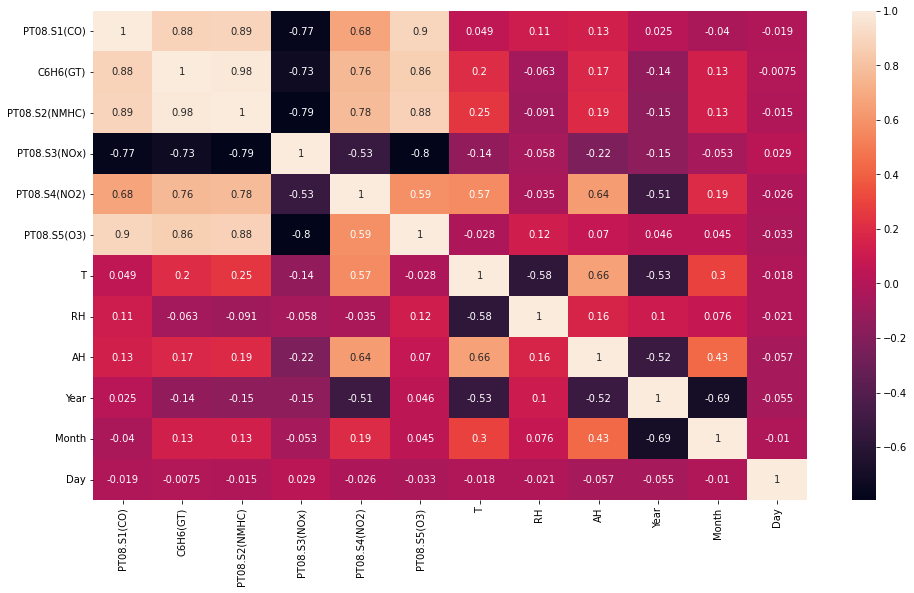

In [ ]:
# S2.2: create a heatmap of a correlation DataFrame of the air quality analysis dataset 
plt.figure(figsize=(16,9))
sns.heatmap(df.corr(),annot=True)
plt.show()

From the heatmap, you can see that, the dependent variable `RH` is moderately correlated with `T` and weakly correlated with carbon monoxide (`'PT08.S1(CO)'`), ozone (`'PT08.S5(O3)'`) , absolute humidity (`AH`) and year (`Year`).

Ideally, to build a multiple linear regression model to predict relative humidity, we should have considered carbon monoxide, ozone, absolute humidity and year independent variables only instead of considering all the independent variables. But among these 4 features: 

- carbon monoxide and ozone are strongly correlated to each other.

- temperature and absolute humidity are moderately correlated to each other.

- temperature and year are moderately correlated to each other.

- absolute humidity and year are moderately correlated to each other.

The above four cases are examples of multicollinearity wherein the independent variables are correlated to each other.

Let's create a correlation heatmap again between the above four features and the dependent variable.

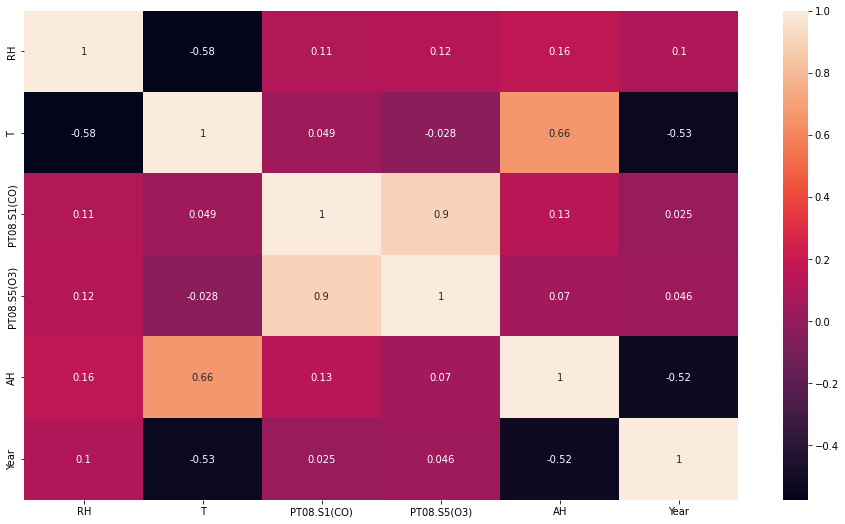

In [ ]:
# S2.3: Create a correlation heatmap between 'RH', 'T', 'PT08.S1(CO)', 'PT08.S5(O3)', 'AH', 'Year' variables.
plt.figure(figsize=(16,9))
sns.heatmap(df[['RH', 'T', 'PT08.S1(CO)', 'PT08.S5(O3)', 'AH', 'Year']].corr(),annot=True)
plt.show()

This multicollinearity causes redundancy because of which we cannot say for sure which of the independent variables are actually contributing to the prediction of the dependent variable.

In this case, to remove multicollinearity, 

- Choose either `T` or `AH` as one of the independent variables. Since the correlation between `RH` and `T` is stronger compared to the correlation between `RH` and `AH`, let's choose `T`.

- Choose either `'PT08.S1(CO)'` or `'PT08.S5(O3)'` as one of the independent variables. Since the correlation between `RH` and `PT08.S5(O3)` is stronger compared to the correlation between `RH` and `'PT08.S1(CO)'`, let's choose `PT08.S5(O3)`.

- Drop `Year` as it is moderately correlated with `'T'`.

Let's create a correlation heatmap again to verify whether the multicollinearity is eliminated or not.

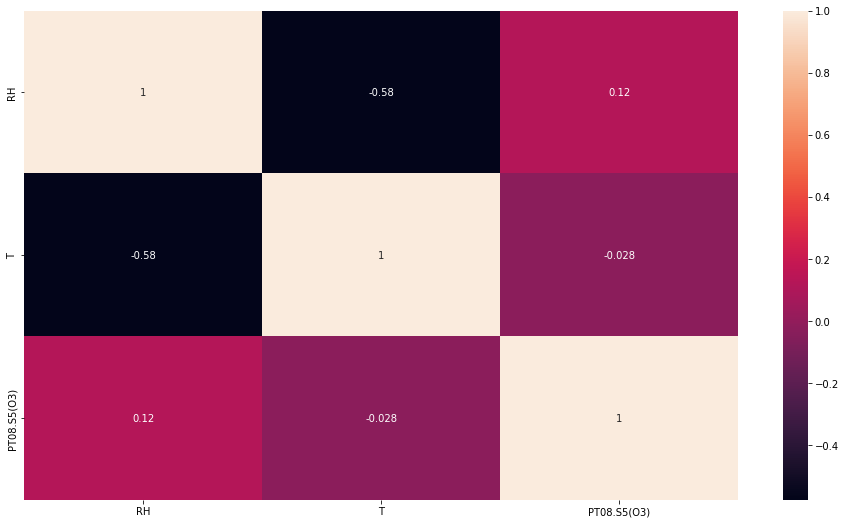

In [ ]:
# S2.4: Create a correlation heatmap between 'RH', 'T', 'PT08.S5(O3)' variables.
plt.figure(figsize=(16,9))
sns.heatmap(df[['RH', 'T', 'PT08.S5(O3)']].corr(),annot=True)
plt.show()

Now that we have removed multicollinearity and selected the features that are likely to contribute best to the prediction of relative humidity values, let's build a linear regression model again using the `statsmodels.api` module.

In [ ]:
# S2.5: Build a linear regression model again with 'T' and 'PT08.S5(O3)' as independent variables to predict 'RH'.
X_train=X_train[['T','PT08.S5(O3)']]
X_test=X_test[['T','PT08.S5(O3)']]

# Add a constant to get an intercept
X_train_sm1=sm.add_constant(X_train)
lr1=sm.OLS(y_train,X_train_sm1).fit()
# Fit the regression line using 'OLS'
lr1.params
# Print the parameters, i.e. the intercept and the slope of the regression line fitted


const          64.956429
T              -1.104251
PT08.S5(O3)     0.004509
dtype: float64

Let's now print the summary table as well.

In [ ]:
# S2.6: Print the summary table to get all the parameters for the features used to build a linear regression model.
print(lr1.summary())

                            OLS Regression Results                            
Dep. Variable:                     RH   R-squared:                       0.335
Model:                            OLS   Adj. R-squared:                  0.335
Method:                 Least Squares   F-statistic:                     1580.
Date:                Tue, 18 Jan 2022   Prob (F-statistic):               0.00
Time:                        04:56:18   Log-Likelihood:                -25378.
No. Observations:                6269   AIC:                         5.076e+04
Df Residuals:                    6266   BIC:                         5.078e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          64.9564      0.623    104.206      

So even after removing multicollinearity, we are getting the same warning again.

Hence you got an idea of multicollinearity and how to deal with it.

Let's stop here. In the next class, we learn how to measure multicollinearity and how much of it is tolerable.

---